To run, use the following command: 

```
docker run -u $(id -u):$(id -g) -it -p 8888:8888 --rm --gpus=all -v ~/raid/andy/Wall-E:/tf/Wall-E tensorflow/tensorflow:latest-gpu-py3-jupyter
```

In [1]:
import sys, os
# grab location where user pip files will be stored
local_site_packages = os.popen("python3 -m site --user-site").read().strip() 
print(local_site_packages)

# and add that location to the sys path so isntalled packages will be included
if not local_site_packages in sys.path:
    sys.path.insert(0,local_site_packages)

print(sys.path)

/.local/lib/python3.6/site-packages
['/.local/lib/python3.6/site-packages', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/tmp/tmpa8i139wo']


In [2]:
!pip3 install --user tensorflow_hub
!pip3 install --user pillow
!pip3 install --user --upgrade cython
!pip3 install --user pycocotools
!pip3 install --user scikit-learn

     |████████████████████████████████| 92kB 881kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 2.1MB 1.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 2.1MB 828kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 1.5MB 970kB/s eta 0:00:01
Failed to build pycocotools
    Running setup.py install for pycocotools ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 7.1MB 837kB/s eta 0:00:01
     |████████████████████████████████| 296kB 2.6MB/s eta

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob
import IPython
from PIL import Image
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split


In [4]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))


In [5]:
## load taco dataset
TACO_PATH = 'data/TACO/'

taco_train_X = []
taco_train_Y = []

globbed_path = glob.glob(TACO_PATH+'*/*.jpg') + glob.glob(TACO_PATH+'*/*.JPG')
print(len(globbed_path))
for impath in globbed_path:
    im = Image.open(impath)
    w, h = im.size
    im = crop_center(im, min(w,h), min(w,h))
    im = im.resize((224,224))
    im = np.asarray(im)/256.0
    if im.shape == (224, 224, 3):
        taco_train_X.append(im)
        taco_train_Y.append(0)

print(len(taco_train_X))

1500
1500


In [9]:
coco=COCO('data/COCO_ann/annotations/instances_train2017.json')

cats = coco.loadCats(coco.getCatIds())

# nms=[cat['name'] for cat in cats]
# print('COCO categories: \n{}\n'.format(' '.join(nms)))

# nms = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(' '.join(nms)))

# no people, animals, boats and planes, or anything indoors
blacklist_id = [cat['id'] for cat in cats if cat['name'] in ['person', 'airplane', 'boat'] or cat['supercategory'] in ['animal','indoor']]
# take images of hydrants and benches that are likely pointed down at the ground 
whitelist_ids = [cat['id'] for cat in cats if cat['name'] in ['fire hydrant', 'bench']]

image_ids = set()

# add in category whitelists
for catId in whitelist_ids:
    for imgid in coco.getImgIds(catIds=catId):
        image_ids.add(imgid)
        
# remove category blacklists
for catId in blacklist_id:
    for imgid in coco.getImgIds(catIds=catId):
        if imgid in image_ids:
            image_ids.remove(imgid)

image_ids = list(image_ids)
print(len(image_ids))


loading annotations into memory...
Done (t=15.18s)
creating index...
index created!
1858


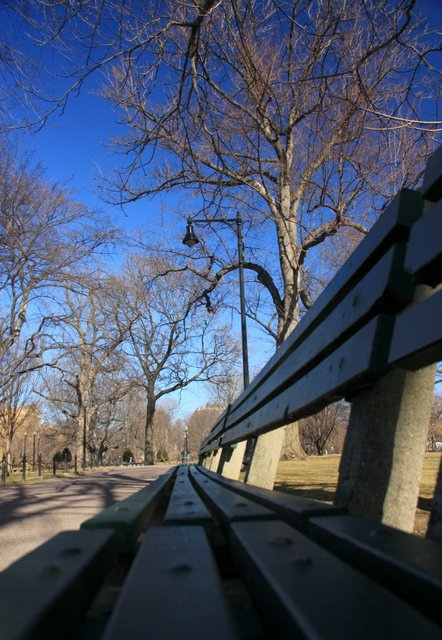

In [10]:
# to get some idea of what is going here, run this line to display a sample images
IPython.display.Image(filename = "data/COCO_train/{0:012d}.jpg".format(image_ids[1]))

In [16]:
COCO_PATH = 'data/COCO_train/'
coco_train_X = []
coco_train_Y = []

print(len(image_ids))

for imid in image_ids:
    im = Image.open(COCO_PATH + "{0:012d}.jpg".format(imid))
    w, h = im.size
    im = crop_center(im, min(w,h), min(w,h))
    im = im.resize((224,224))
    im = np.asarray(im)/256.0
    if im.shape == (224, 224, 3):
        coco_train_X.append(im)
        coco_train_Y.append(1)


print(len(coco_train_X))

1858
1857


In [17]:
X_all = np.array(taco_train_X + coco_train_X)
Y_all = np.array(taco_train_Y + coco_train_Y)

X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.1, random_state=42)


In [18]:
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
                   trainable=False),  # Can be True.
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.build([None, 224, 224, 3])  # Batch input shape.

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss='binary_crossentropy',  # From information theory notebooks.
              metrics=['accuracy'])        # What metric to output as we train.

In [19]:
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))

Train on 3021 samples, validate on 336 samples
Epoch 1/10
3021/3021 [==============================] - 12s 4ms/sample - loss: 0.6308 - accuracy: 0.6736 - val_loss: 0.5130 - val_accuracy: 0.7440
Epoch 2/10
3021/3021 [==============================] - 7s 2ms/sample - loss: 0.4503 - accuracy: 0.7918 - val_loss: 0.3995 - val_accuracy: 0.8304
Epoch 3/10
3021/3021 [==============================] - 7s 2ms/sample - loss: 0.3613 - accuracy: 0.8577 - val_loss: 0.3376 - val_accuracy: 0.8542
Epoch 4/10
3021/3021 [==============================] - 8s 2ms/sample - loss: 0.3079 - accuracy: 0.8802 - val_loss: 0.2982 - val_accuracy: 0.8690
Epoch 5/10
3021/3021 [==============================] - 8s 2ms/sample - loss: 0.2722 - accuracy: 0.9024 - val_loss: 0.2711 - val_accuracy: 0.8839
Epoch 6/10
3021/3021 [==============================] - 8s 2ms/sample - loss: 0.2466 - accuracy: 0.9159 - val_loss: 0.2513 - val_accuracy: 0.8958
Epoch 7/10
3021/3021 [==============================] - 8s 2ms/sample - loss